In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2025 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
#
###############################################################################

In [2]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2023 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

# Supercritical CO2 Property Surrogate with OMLT Surrogate Object - Training Surrogate (Part 1)

Maintainer: Javal Vyas

Author: Javal Vyas

Updated: 2024-01-24

## 1. Introduction
This notebook illustrates the use of KerasSurrogate API leveraging TensorFlow Keras and OMLT package to produce an ML surrogate based on supercritical CO2 data from simulation using REFPROP package.

There are several reasons to build surrogate models for complex processes, even when higher fidelity models already exist (e.g., reduce model size, improve convergence reliability, replace models with externally compiled code and make them fully-equation oriented).

In this example, we intend to make a surrogate for the physical properties of S-CO2 to be embedded in the property package. This property package will be used to get the physical properties of S-CO2 in the flowsheet simulation. To learn more about property package, see the [IDAES-PSE](https://github.com/IDAES/idaes-pse) Github Page or IDAES [Read-the-docs](https://idaes-pse.readthedocs.io/en/latest/). 

### 1.1 Need for ML Surrogates

The properties predicted by the surrogate are enthalpy and entropy of the S-CO2 based on the 
pressure and temperature of the system. The analytical equation of getting the enthalpy and entropy from pressure and temperature are in the differential form and would make the problem a DAE system. To counter this problem and keep the problem algebraic, we will use the ML surrogates and relate enthalpy and entropy with the pressure and temperature as an algebraic equation.

### 1.2 Supercritical CO2 cycle process

The following flowsheet will be used to optimize the design for the cooling of the fusion reactor using supercritical CO2 cycle. We shall focus on training the surrogate for this notebook and move to constructing the flowsheet and the properties package in the subsequent notebooks. The take away from this flowsheet is that, 3 variables can be measured in any given unit which are flow, pressure and temperature and other properties can be calculated using them. Thus, surrogate should have pressure and temperature as the inputs.

In this example, we will train a tanh model from our data and then demonstrate that we can solve an optimization problem with that surrogate model. 

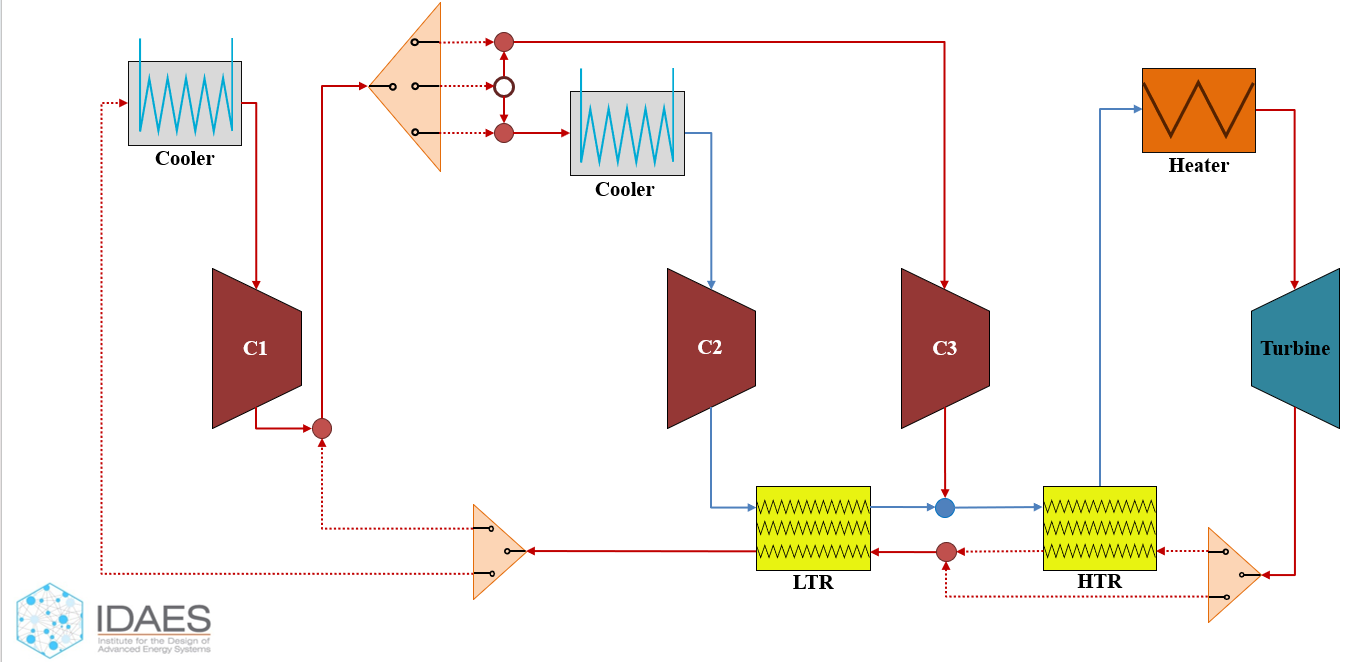

In [3]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("CO2_flowsheet.png"))

## 2. Training and Validating Surrogate

First, let's import the required Python and IDAES modules:

In [4]:
# Import statements
import os
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import tensorflow.keras as keras

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from idaes.core.surrogate.keras_surrogate import KerasSurrogate
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)

# fix environment variables to ensure consist neural network training
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(46)
rn.seed(1342)
tf.random.set_seed(62)

2025-03-17 17:38:42.032800: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 17:38:42.033487: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 17:38:42.036537: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 17:38:42.043175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742258322.054590  362852 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742258322.05

### 2.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 500 data points were simulated for S-CO2 physical properties using REFPROP package. This example is trained on the entire dataset because neural  network can overfit on smaller dataset. The data is separated using an 80/20 split into training and validation data using the IDAES split_training_validation() method.

We rename the column headers because they contained ".", which may cause errors while reading the column names in subsequent code, thus as a good practice we change them to the variable names to be used in the property package. Further, the input variables are **pressure**, **temperature** , while the output variables are **enth_mol**, **entr_mol**, hence we create two new dataframes for the input and output variables. 

In [5]:
# Import training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(datafile_path("500_Points_DataSet.csv"))
csv_data.columns.values[0:6] = [
    "pressure",
    "temperature",
    "enth_mol",
    "entr_mol",
    "CO2_enthalpy",
    "CO2_entropy",
]
data = csv_data.sample(n=500)

# Creating input_data and output_data from data
input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:4]

# Define labels, and split training and validation data
input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(data, 0.8, seed=n_data)

/home/dang/miniforge3/envs/idaes_examples_py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### 2.2 Training Surrogate with TensorFlow Keras
TensorFlow Keras provides an interface to pass regression settings, build neural networks and train surrogate models. Keras enables the usage of two API formats: Sequential and Functional. While the Functional API offers more versatility, including multiple input and output layers in a single neural network, the Sequential API is more stable and user-friendly. Further, the Sequential API integrates cleanly with existing IDAES surrogate tools and will be utilized in this example.

In the code below, we build the neural network structure based on our training data structure and desired regression settings. Offline, neural network models were trained for the list of settings below, and the options bolded and italicized were determined to have the minimum mean squared error for the dataset:

* Activation function: sigmoid, **tanh**
* Optimizer: **Adam**
* Number of hidden layers: 3, **4**, 5, 6
* Number of neurons per layer: **20**, 40, 60

Important thing to note here is that we do not use ReLU activation function for the training as the flowsheet we intend to solve with this surrogate model is a NLP problem and using ReLU activation function will make it an MINLP. Another thing to note here is the network is smaller (4,20) in order to avoid overfitting.  

Typically, Sequential Keras models are built vertically; the dataset is scaled and normalized. The network is defined for the input layer, hidden layers, and output layer for the passed activation functions and network/layer sizes. Then, the model is compiled using the passed optimizer and trained using a desired number of epochs. Keras internally validates while training and updates each epoch's model weight (coefficient) values.

Finally, after training the model, we save the results and model expressions to a folder that contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

Epoch 1/250


/home/dang/miniforge3/envs/idaes_examples_py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-17 17:38:44.131094: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


13/13 - 1s - 84ms/step - loss: 0.0188 - mae: 0.0963 - mse: 0.0188 - val_loss: 0.0043 - val_mae: 0.0456 - val_mse: 0.0043


Epoch 2/250


13/13 - 0s - 6ms/step - loss: 0.0034 - mae: 0.0438 - mse: 0.0034 - val_loss: 0.0031 - val_mae: 0.0438 - val_mse: 0.0031


Epoch 3/250


13/13 - 0s - 5ms/step - loss: 0.0023 - mae: 0.0382 - mse: 0.0023 - val_loss: 0.0018 - val_mae: 0.0349 - val_mse: 0.0018


Epoch 4/250


13/13 - 0s - 6ms/step - loss: 0.0016 - mae: 0.0297 - mse: 0.0016 - val_loss: 0.0014 - val_mae: 0.0274 - val_mse: 0.0014


Epoch 5/250


13/13 - 0s - 7ms/step - loss: 0.0015 - mae: 0.0280 - mse: 0.0015 - val_loss: 0.0013 - val_mae: 0.0279 - val_mse: 0.0013


Epoch 6/250


13/13 - 0s - 7ms/step - loss: 0.0013 - mae: 0.0279 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0279 - val_mse: 0.0013


Epoch 7/250


13/13 - 0s - 6ms/step - loss: 0.0012 - mae: 0.0268 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0263 - val_mse: 0.0012


Epoch 8/250


13/13 - 0s - 6ms/step - loss: 0.0012 - mae: 0.0259 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0260 - val_mse: 0.0011


Epoch 9/250


13/13 - 0s - 7ms/step - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0257 - val_mse: 0.0011


Epoch 10/250


13/13 - 0s - 7ms/step - loss: 0.0011 - mae: 0.0247 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011


Epoch 11/250


13/13 - 0s - 9ms/step - loss: 0.0010 - mae: 0.0241 - mse: 0.0010 - val_loss: 0.0010 - val_mae: 0.0246 - val_mse: 0.0010


Epoch 12/250


13/13 - 0s - 7ms/step - loss: 9.6390e-04 - mae: 0.0236 - mse: 9.6390e-04 - val_loss: 9.5685e-04 - val_mae: 0.0240 - val_mse: 9.5685e-04


Epoch 13/250


13/13 - 0s - 6ms/step - loss: 9.2020e-04 - mae: 0.0230 - mse: 9.2020e-04 - val_loss: 9.0503e-04 - val_mae: 0.0234 - val_mse: 9.0503e-04


Epoch 14/250


13/13 - 0s - 7ms/step - loss: 8.8350e-04 - mae: 0.0226 - mse: 8.8350e-04 - val_loss: 8.6211e-04 - val_mae: 0.0229 - val_mse: 8.6211e-04


Epoch 15/250


13/13 - 0s - 6ms/step - loss: 8.5257e-04 - mae: 0.0223 - mse: 8.5257e-04 - val_loss: 8.2819e-04 - val_mae: 0.0224 - val_mse: 8.2819e-04


Epoch 16/250


13/13 - 0s - 6ms/step - loss: 8.2619e-04 - mae: 0.0220 - mse: 8.2619e-04 - val_loss: 8.0146e-04 - val_mae: 0.0221 - val_mse: 8.0146e-04


Epoch 17/250


13/13 - 0s - 7ms/step - loss: 8.0318e-04 - mae: 0.0217 - mse: 8.0318e-04 - val_loss: 7.7882e-04 - val_mae: 0.0218 - val_mse: 7.7882e-04


Epoch 18/250


13/13 - 0s - 6ms/step - loss: 7.8315e-04 - mae: 0.0215 - mse: 7.8315e-04 - val_loss: 7.5925e-04 - val_mae: 0.0215 - val_mse: 7.5925e-04


Epoch 19/250


13/13 - 0s - 6ms/step - loss: 7.6577e-04 - mae: 0.0213 - mse: 7.6577e-04 - val_loss: 7.4256e-04 - val_mae: 0.0212 - val_mse: 7.4256e-04


Epoch 20/250


13/13 - 0s - 6ms/step - loss: 7.5078e-04 - mae: 0.0212 - mse: 7.5078e-04 - val_loss: 7.2850e-04 - val_mae: 0.0210 - val_mse: 7.2850e-04


Epoch 21/250


13/13 - 0s - 6ms/step - loss: 7.3792e-04 - mae: 0.0210 - mse: 7.3792e-04 - val_loss: 7.1661e-04 - val_mae: 0.0208 - val_mse: 7.1661e-04


Epoch 22/250


13/13 - 0s - 6ms/step - loss: 7.2692e-04 - mae: 0.0209 - mse: 7.2692e-04 - val_loss: 7.0647e-04 - val_mae: 0.0207 - val_mse: 7.0647e-04


Epoch 23/250


13/13 - 0s - 7ms/step - loss: 7.1753e-04 - mae: 0.0208 - mse: 7.1753e-04 - val_loss: 6.9782e-04 - val_mae: 0.0206 - val_mse: 6.9782e-04


Epoch 24/250


13/13 - 0s - 5ms/step - loss: 7.0953e-04 - mae: 0.0208 - mse: 7.0953e-04 - val_loss: 6.9039e-04 - val_mae: 0.0205 - val_mse: 6.9039e-04


Epoch 25/250


13/13 - 0s - 8ms/step - loss: 7.0270e-04 - mae: 0.0207 - mse: 7.0270e-04 - val_loss: 6.8392e-04 - val_mae: 0.0204 - val_mse: 6.8392e-04


Epoch 26/250


13/13 - 0s - 8ms/step - loss: 6.9683e-04 - mae: 0.0207 - mse: 6.9683e-04 - val_loss: 6.7824e-04 - val_mae: 0.0203 - val_mse: 6.7824e-04


Epoch 27/250


13/13 - 0s - 7ms/step - loss: 6.9177e-04 - mae: 0.0206 - mse: 6.9177e-04 - val_loss: 6.7317e-04 - val_mae: 0.0203 - val_mse: 6.7317e-04


Epoch 28/250


13/13 - 0s - 7ms/step - loss: 6.8736e-04 - mae: 0.0206 - mse: 6.8736e-04 - val_loss: 6.6858e-04 - val_mae: 0.0202 - val_mse: 6.6858e-04


Epoch 29/250


13/13 - 0s - 7ms/step - loss: 6.8348e-04 - mae: 0.0205 - mse: 6.8348e-04 - val_loss: 6.6437e-04 - val_mae: 0.0201 - val_mse: 6.6437e-04


Epoch 30/250


13/13 - 0s - 8ms/step - loss: 6.8002e-04 - mae: 0.0205 - mse: 6.8002e-04 - val_loss: 6.6044e-04 - val_mae: 0.0201 - val_mse: 6.6044e-04


Epoch 31/250


13/13 - 0s - 6ms/step - loss: 6.7689e-04 - mae: 0.0205 - mse: 6.7689e-04 - val_loss: 6.5676e-04 - val_mae: 0.0200 - val_mse: 6.5676e-04


Epoch 32/250


13/13 - 0s - 7ms/step - loss: 6.7403e-04 - mae: 0.0204 - mse: 6.7403e-04 - val_loss: 6.5325e-04 - val_mae: 0.0200 - val_mse: 6.5325e-04


Epoch 33/250


13/13 - 0s - 7ms/step - loss: 6.7138e-04 - mae: 0.0204 - mse: 6.7138e-04 - val_loss: 6.4990e-04 - val_mae: 0.0199 - val_mse: 6.4990e-04


Epoch 34/250


13/13 - 0s - 6ms/step - loss: 6.6889e-04 - mae: 0.0204 - mse: 6.6889e-04 - val_loss: 6.4668e-04 - val_mae: 0.0199 - val_mse: 6.4668e-04


Epoch 35/250


13/13 - 0s - 5ms/step - loss: 6.6654e-04 - mae: 0.0203 - mse: 6.6654e-04 - val_loss: 6.4356e-04 - val_mae: 0.0198 - val_mse: 6.4356e-04


Epoch 36/250


13/13 - 0s - 6ms/step - loss: 6.6429e-04 - mae: 0.0203 - mse: 6.6429e-04 - val_loss: 6.4054e-04 - val_mae: 0.0198 - val_mse: 6.4054e-04


Epoch 37/250


13/13 - 0s - 6ms/step - loss: 6.6212e-04 - mae: 0.0203 - mse: 6.6212e-04 - val_loss: 6.3761e-04 - val_mae: 0.0197 - val_mse: 6.3761e-04


Epoch 38/250


13/13 - 0s - 6ms/step - loss: 6.6001e-04 - mae: 0.0203 - mse: 6.6001e-04 - val_loss: 6.3475e-04 - val_mae: 0.0197 - val_mse: 6.3475e-04


Epoch 39/250


13/13 - 0s - 7ms/step - loss: 6.5795e-04 - mae: 0.0202 - mse: 6.5795e-04 - val_loss: 6.3196e-04 - val_mae: 0.0197 - val_mse: 6.3196e-04


Epoch 40/250


13/13 - 0s - 6ms/step - loss: 6.5593e-04 - mae: 0.0202 - mse: 6.5593e-04 - val_loss: 6.2924e-04 - val_mae: 0.0196 - val_mse: 6.2924e-04


Epoch 41/250


13/13 - 0s - 7ms/step - loss: 6.5392e-04 - mae: 0.0202 - mse: 6.5392e-04 - val_loss: 6.2658e-04 - val_mae: 0.0196 - val_mse: 6.2658e-04


Epoch 42/250


13/13 - 0s - 6ms/step - loss: 6.5194e-04 - mae: 0.0201 - mse: 6.5194e-04 - val_loss: 6.2397e-04 - val_mae: 0.0195 - val_mse: 6.2397e-04


Epoch 43/250


13/13 - 0s - 6ms/step - loss: 6.4996e-04 - mae: 0.0201 - mse: 6.4996e-04 - val_loss: 6.2141e-04 - val_mae: 0.0195 - val_mse: 6.2141e-04


Epoch 44/250


13/13 - 0s - 7ms/step - loss: 6.4799e-04 - mae: 0.0201 - mse: 6.4799e-04 - val_loss: 6.1891e-04 - val_mae: 0.0194 - val_mse: 6.1891e-04


Epoch 45/250


13/13 - 0s - 6ms/step - loss: 6.4602e-04 - mae: 0.0200 - mse: 6.4602e-04 - val_loss: 6.1645e-04 - val_mae: 0.0194 - val_mse: 6.1645e-04


Epoch 46/250


13/13 - 0s - 7ms/step - loss: 6.4405e-04 - mae: 0.0200 - mse: 6.4405e-04 - val_loss: 6.1403e-04 - val_mae: 0.0193 - val_mse: 6.1403e-04


Epoch 47/250


13/13 - 0s - 6ms/step - loss: 6.4207e-04 - mae: 0.0200 - mse: 6.4207e-04 - val_loss: 6.1164e-04 - val_mae: 0.0193 - val_mse: 6.1164e-04


Epoch 48/250


13/13 - 0s - 6ms/step - loss: 6.4009e-04 - mae: 0.0199 - mse: 6.4009e-04 - val_loss: 6.0930e-04 - val_mae: 0.0193 - val_mse: 6.0930e-04


Epoch 49/250


13/13 - 0s - 8ms/step - loss: 6.3810e-04 - mae: 0.0199 - mse: 6.3810e-04 - val_loss: 6.0698e-04 - val_mae: 0.0192 - val_mse: 6.0698e-04


Epoch 50/250


13/13 - 0s - 5ms/step - loss: 6.3611e-04 - mae: 0.0199 - mse: 6.3611e-04 - val_loss: 6.0470e-04 - val_mae: 0.0192 - val_mse: 6.0470e-04


Epoch 51/250


13/13 - 0s - 7ms/step - loss: 6.3410e-04 - mae: 0.0199 - mse: 6.3410e-04 - val_loss: 6.0244e-04 - val_mae: 0.0191 - val_mse: 6.0244e-04


Epoch 52/250


13/13 - 0s - 7ms/step - loss: 6.3209e-04 - mae: 0.0198 - mse: 6.3209e-04 - val_loss: 6.0021e-04 - val_mae: 0.0191 - val_mse: 6.0021e-04


Epoch 53/250


13/13 - 0s - 9ms/step - loss: 6.3006e-04 - mae: 0.0198 - mse: 6.3006e-04 - val_loss: 5.9800e-04 - val_mae: 0.0190 - val_mse: 5.9800e-04


Epoch 54/250


13/13 - 0s - 8ms/step - loss: 6.2803e-04 - mae: 0.0198 - mse: 6.2803e-04 - val_loss: 5.9581e-04 - val_mae: 0.0190 - val_mse: 5.9581e-04


Epoch 55/250


13/13 - 0s - 7ms/step - loss: 6.2599e-04 - mae: 0.0197 - mse: 6.2599e-04 - val_loss: 5.9364e-04 - val_mae: 0.0190 - val_mse: 5.9364e-04


Epoch 56/250


13/13 - 0s - 6ms/step - loss: 6.2394e-04 - mae: 0.0197 - mse: 6.2394e-04 - val_loss: 5.9149e-04 - val_mae: 0.0189 - val_mse: 5.9149e-04


Epoch 57/250


13/13 - 0s - 6ms/step - loss: 6.2188e-04 - mae: 0.0197 - mse: 6.2188e-04 - val_loss: 5.8935e-04 - val_mae: 0.0189 - val_mse: 5.8935e-04


Epoch 58/250


13/13 - 0s - 7ms/step - loss: 6.1981e-04 - mae: 0.0196 - mse: 6.1981e-04 - val_loss: 5.8723e-04 - val_mae: 0.0188 - val_mse: 5.8723e-04


Epoch 59/250


13/13 - 0s - 7ms/step - loss: 6.1773e-04 - mae: 0.0196 - mse: 6.1773e-04 - val_loss: 5.8513e-04 - val_mae: 0.0188 - val_mse: 5.8513e-04


Epoch 60/250


13/13 - 0s - 5ms/step - loss: 6.1564e-04 - mae: 0.0196 - mse: 6.1564e-04 - val_loss: 5.8304e-04 - val_mae: 0.0188 - val_mse: 5.8304e-04


Epoch 61/250


13/13 - 0s - 6ms/step - loss: 6.1355e-04 - mae: 0.0195 - mse: 6.1355e-04 - val_loss: 5.8096e-04 - val_mae: 0.0187 - val_mse: 5.8096e-04


Epoch 62/250


13/13 - 0s - 6ms/step - loss: 6.1144e-04 - mae: 0.0195 - mse: 6.1144e-04 - val_loss: 5.7890e-04 - val_mae: 0.0187 - val_mse: 5.7890e-04


Epoch 63/250


13/13 - 0s - 6ms/step - loss: 6.0933e-04 - mae: 0.0195 - mse: 6.0933e-04 - val_loss: 5.7685e-04 - val_mae: 0.0186 - val_mse: 5.7685e-04


Epoch 64/250


13/13 - 0s - 6ms/step - loss: 6.0720e-04 - mae: 0.0194 - mse: 6.0720e-04 - val_loss: 5.7481e-04 - val_mae: 0.0186 - val_mse: 5.7481e-04


Epoch 65/250


13/13 - 0s - 7ms/step - loss: 6.0508e-04 - mae: 0.0194 - mse: 6.0508e-04 - val_loss: 5.7279e-04 - val_mae: 0.0186 - val_mse: 5.7279e-04


Epoch 66/250


13/13 - 0s - 6ms/step - loss: 6.0294e-04 - mae: 0.0194 - mse: 6.0294e-04 - val_loss: 5.7077e-04 - val_mae: 0.0185 - val_mse: 5.7077e-04


Epoch 67/250


13/13 - 0s - 6ms/step - loss: 6.0079e-04 - mae: 0.0193 - mse: 6.0079e-04 - val_loss: 5.6877e-04 - val_mae: 0.0185 - val_mse: 5.6877e-04


Epoch 68/250


13/13 - 0s - 6ms/step - loss: 5.9864e-04 - mae: 0.0193 - mse: 5.9864e-04 - val_loss: 5.6678e-04 - val_mae: 0.0185 - val_mse: 5.6678e-04


Epoch 69/250


13/13 - 0s - 7ms/step - loss: 5.9648e-04 - mae: 0.0193 - mse: 5.9648e-04 - val_loss: 5.6480e-04 - val_mae: 0.0184 - val_mse: 5.6480e-04


Epoch 70/250


13/13 - 0s - 7ms/step - loss: 5.9431e-04 - mae: 0.0192 - mse: 5.9431e-04 - val_loss: 5.6284e-04 - val_mae: 0.0184 - val_mse: 5.6284e-04


Epoch 71/250


13/13 - 0s - 7ms/step - loss: 5.9214e-04 - mae: 0.0192 - mse: 5.9214e-04 - val_loss: 5.6089e-04 - val_mae: 0.0183 - val_mse: 5.6089e-04


Epoch 72/250


13/13 - 0s - 5ms/step - loss: 5.8997e-04 - mae: 0.0192 - mse: 5.8997e-04 - val_loss: 5.5895e-04 - val_mae: 0.0183 - val_mse: 5.5895e-04


Epoch 73/250


13/13 - 0s - 5ms/step - loss: 5.8778e-04 - mae: 0.0191 - mse: 5.8778e-04 - val_loss: 5.5703e-04 - val_mae: 0.0183 - val_mse: 5.5703e-04


Epoch 74/250


13/13 - 0s - 7ms/step - loss: 5.8560e-04 - mae: 0.0191 - mse: 5.8560e-04 - val_loss: 5.5512e-04 - val_mae: 0.0182 - val_mse: 5.5512e-04


Epoch 75/250


13/13 - 0s - 7ms/step - loss: 5.8341e-04 - mae: 0.0191 - mse: 5.8341e-04 - val_loss: 5.5322e-04 - val_mae: 0.0182 - val_mse: 5.5322e-04


Epoch 76/250


13/13 - 0s - 6ms/step - loss: 5.8122e-04 - mae: 0.0190 - mse: 5.8122e-04 - val_loss: 5.5134e-04 - val_mae: 0.0182 - val_mse: 5.5134e-04


Epoch 77/250


13/13 - 0s - 5ms/step - loss: 5.7902e-04 - mae: 0.0190 - mse: 5.7902e-04 - val_loss: 5.4947e-04 - val_mae: 0.0181 - val_mse: 5.4947e-04


Epoch 78/250


13/13 - 0s - 7ms/step - loss: 5.7683e-04 - mae: 0.0190 - mse: 5.7683e-04 - val_loss: 5.4761e-04 - val_mae: 0.0181 - val_mse: 5.4761e-04


Epoch 79/250


13/13 - 0s - 6ms/step - loss: 5.7463e-04 - mae: 0.0189 - mse: 5.7463e-04 - val_loss: 5.4577e-04 - val_mae: 0.0181 - val_mse: 5.4577e-04


Epoch 80/250


13/13 - 0s - 8ms/step - loss: 5.7244e-04 - mae: 0.0189 - mse: 5.7244e-04 - val_loss: 5.4394e-04 - val_mae: 0.0180 - val_mse: 5.4394e-04


Epoch 81/250


13/13 - 0s - 6ms/step - loss: 5.7024e-04 - mae: 0.0189 - mse: 5.7024e-04 - val_loss: 5.4212e-04 - val_mae: 0.0180 - val_mse: 5.4212e-04


Epoch 82/250


13/13 - 0s - 6ms/step - loss: 5.6805e-04 - mae: 0.0188 - mse: 5.6805e-04 - val_loss: 5.4031e-04 - val_mae: 0.0179 - val_mse: 5.4031e-04


Epoch 83/250


13/13 - 0s - 6ms/step - loss: 5.6586e-04 - mae: 0.0188 - mse: 5.6586e-04 - val_loss: 5.3850e-04 - val_mae: 0.0179 - val_mse: 5.3850e-04


Epoch 84/250


13/13 - 0s - 8ms/step - loss: 5.6368e-04 - mae: 0.0188 - mse: 5.6368e-04 - val_loss: 5.3671e-04 - val_mae: 0.0179 - val_mse: 5.3671e-04


Epoch 85/250


13/13 - 0s - 7ms/step - loss: 5.6150e-04 - mae: 0.0187 - mse: 5.6150e-04 - val_loss: 5.3492e-04 - val_mae: 0.0178 - val_mse: 5.3492e-04


Epoch 86/250


13/13 - 0s - 8ms/step - loss: 5.5932e-04 - mae: 0.0187 - mse: 5.5932e-04 - val_loss: 5.3313e-04 - val_mae: 0.0178 - val_mse: 5.3313e-04


Epoch 87/250


13/13 - 0s - 8ms/step - loss: 5.5715e-04 - mae: 0.0187 - mse: 5.5715e-04 - val_loss: 5.3134e-04 - val_mae: 0.0178 - val_mse: 5.3134e-04


Epoch 88/250


13/13 - 0s - 6ms/step - loss: 5.5499e-04 - mae: 0.0186 - mse: 5.5499e-04 - val_loss: 5.2955e-04 - val_mae: 0.0177 - val_mse: 5.2955e-04


Epoch 89/250


13/13 - 0s - 6ms/step - loss: 5.5284e-04 - mae: 0.0186 - mse: 5.5284e-04 - val_loss: 5.2776e-04 - val_mae: 0.0177 - val_mse: 5.2776e-04


Epoch 90/250


13/13 - 0s - 6ms/step - loss: 5.5069e-04 - mae: 0.0186 - mse: 5.5069e-04 - val_loss: 5.2595e-04 - val_mae: 0.0177 - val_mse: 5.2595e-04


Epoch 91/250


13/13 - 0s - 10ms/step - loss: 5.4855e-04 - mae: 0.0185 - mse: 5.4855e-04 - val_loss: 5.2414e-04 - val_mae: 0.0177 - val_mse: 5.2414e-04


Epoch 92/250


13/13 - 0s - 8ms/step - loss: 5.4642e-04 - mae: 0.0185 - mse: 5.4642e-04 - val_loss: 5.2230e-04 - val_mae: 0.0176 - val_mse: 5.2230e-04


Epoch 93/250


13/13 - 0s - 8ms/step - loss: 5.4431e-04 - mae: 0.0185 - mse: 5.4431e-04 - val_loss: 5.2045e-04 - val_mae: 0.0176 - val_mse: 5.2045e-04


Epoch 94/250


13/13 - 0s - 6ms/step - loss: 5.4220e-04 - mae: 0.0184 - mse: 5.4220e-04 - val_loss: 5.1858e-04 - val_mae: 0.0175 - val_mse: 5.1858e-04


Epoch 95/250


13/13 - 0s - 6ms/step - loss: 5.4010e-04 - mae: 0.0184 - mse: 5.4010e-04 - val_loss: 5.1669e-04 - val_mae: 0.0175 - val_mse: 5.1669e-04


Epoch 96/250


13/13 - 0s - 5ms/step - loss: 5.3802e-04 - mae: 0.0184 - mse: 5.3802e-04 - val_loss: 5.1476e-04 - val_mae: 0.0175 - val_mse: 5.1476e-04


Epoch 97/250


13/13 - 0s - 8ms/step - loss: 5.3595e-04 - mae: 0.0183 - mse: 5.3595e-04 - val_loss: 5.1281e-04 - val_mae: 0.0174 - val_mse: 5.1281e-04


Epoch 98/250


13/13 - 0s - 6ms/step - loss: 5.3388e-04 - mae: 0.0183 - mse: 5.3388e-04 - val_loss: 5.1082e-04 - val_mae: 0.0174 - val_mse: 5.1082e-04


Epoch 99/250


13/13 - 0s - 6ms/step - loss: 5.3184e-04 - mae: 0.0182 - mse: 5.3184e-04 - val_loss: 5.0880e-04 - val_mae: 0.0174 - val_mse: 5.0880e-04


Epoch 100/250


13/13 - 0s - 6ms/step - loss: 5.2980e-04 - mae: 0.0182 - mse: 5.2980e-04 - val_loss: 5.0674e-04 - val_mae: 0.0173 - val_mse: 5.0674e-04


Epoch 101/250


13/13 - 0s - 5ms/step - loss: 5.2777e-04 - mae: 0.0182 - mse: 5.2777e-04 - val_loss: 5.0465e-04 - val_mae: 0.0173 - val_mse: 5.0465e-04


Epoch 102/250


13/13 - 0s - 7ms/step - loss: 5.2575e-04 - mae: 0.0181 - mse: 5.2575e-04 - val_loss: 5.0252e-04 - val_mae: 0.0172 - val_mse: 5.0252e-04


Epoch 103/250


13/13 - 0s - 6ms/step - loss: 5.2374e-04 - mae: 0.0181 - mse: 5.2374e-04 - val_loss: 5.0036e-04 - val_mae: 0.0172 - val_mse: 5.0036e-04


Epoch 104/250


13/13 - 0s - 6ms/step - loss: 5.2173e-04 - mae: 0.0181 - mse: 5.2173e-04 - val_loss: 4.9817e-04 - val_mae: 0.0171 - val_mse: 4.9817e-04


Epoch 105/250


13/13 - 0s - 6ms/step - loss: 5.1972e-04 - mae: 0.0180 - mse: 5.1972e-04 - val_loss: 4.9596e-04 - val_mae: 0.0171 - val_mse: 4.9596e-04


Epoch 106/250


13/13 - 0s - 8ms/step - loss: 5.1770e-04 - mae: 0.0180 - mse: 5.1770e-04 - val_loss: 4.9373e-04 - val_mae: 0.0170 - val_mse: 4.9373e-04


Epoch 107/250


13/13 - 0s - 7ms/step - loss: 5.1566e-04 - mae: 0.0180 - mse: 5.1566e-04 - val_loss: 4.9150e-04 - val_mae: 0.0169 - val_mse: 4.9150e-04


Epoch 108/250


13/13 - 0s - 6ms/step - loss: 5.1361e-04 - mae: 0.0179 - mse: 5.1361e-04 - val_loss: 4.8926e-04 - val_mae: 0.0169 - val_mse: 4.8926e-04


Epoch 109/250


13/13 - 0s - 8ms/step - loss: 5.1152e-04 - mae: 0.0179 - mse: 5.1152e-04 - val_loss: 4.8704e-04 - val_mae: 0.0168 - val_mse: 4.8704e-04


Epoch 110/250


13/13 - 0s - 6ms/step - loss: 5.0940e-04 - mae: 0.0178 - mse: 5.0940e-04 - val_loss: 4.8484e-04 - val_mae: 0.0168 - val_mse: 4.8484e-04


Epoch 111/250


13/13 - 0s - 6ms/step - loss: 5.0723e-04 - mae: 0.0178 - mse: 5.0723e-04 - val_loss: 4.8268e-04 - val_mae: 0.0167 - val_mse: 4.8268e-04


Epoch 112/250


13/13 - 0s - 6ms/step - loss: 5.0500e-04 - mae: 0.0177 - mse: 5.0500e-04 - val_loss: 4.8055e-04 - val_mae: 0.0166 - val_mse: 4.8055e-04


Epoch 113/250


13/13 - 0s - 6ms/step - loss: 5.0271e-04 - mae: 0.0177 - mse: 5.0271e-04 - val_loss: 4.7846e-04 - val_mae: 0.0166 - val_mse: 4.7846e-04


Epoch 114/250


13/13 - 0s - 5ms/step - loss: 5.0035e-04 - mae: 0.0176 - mse: 5.0035e-04 - val_loss: 4.7642e-04 - val_mae: 0.0165 - val_mse: 4.7642e-04


Epoch 115/250


13/13 - 0s - 5ms/step - loss: 4.9791e-04 - mae: 0.0176 - mse: 4.9791e-04 - val_loss: 4.7443e-04 - val_mae: 0.0164 - val_mse: 4.7443e-04


Epoch 116/250


13/13 - 0s - 6ms/step - loss: 4.9541e-04 - mae: 0.0175 - mse: 4.9541e-04 - val_loss: 4.7248e-04 - val_mae: 0.0164 - val_mse: 4.7248e-04


Epoch 117/250


13/13 - 0s - 7ms/step - loss: 4.9282e-04 - mae: 0.0175 - mse: 4.9282e-04 - val_loss: 4.7056e-04 - val_mae: 0.0163 - val_mse: 4.7056e-04


Epoch 118/250


13/13 - 0s - 7ms/step - loss: 4.9018e-04 - mae: 0.0174 - mse: 4.9018e-04 - val_loss: 4.6866e-04 - val_mae: 0.0163 - val_mse: 4.6866e-04


Epoch 119/250


13/13 - 0s - 5ms/step - loss: 4.8747e-04 - mae: 0.0174 - mse: 4.8747e-04 - val_loss: 4.6678e-04 - val_mae: 0.0162 - val_mse: 4.6678e-04


Epoch 120/250


13/13 - 0s - 5ms/step - loss: 4.8471e-04 - mae: 0.0173 - mse: 4.8471e-04 - val_loss: 4.6490e-04 - val_mae: 0.0161 - val_mse: 4.6490e-04


Epoch 121/250


13/13 - 0s - 7ms/step - loss: 4.8192e-04 - mae: 0.0173 - mse: 4.8192e-04 - val_loss: 4.6302e-04 - val_mae: 0.0161 - val_mse: 4.6302e-04


Epoch 122/250


13/13 - 0s - 7ms/step - loss: 4.7910e-04 - mae: 0.0172 - mse: 4.7910e-04 - val_loss: 4.6112e-04 - val_mae: 0.0160 - val_mse: 4.6112e-04


Epoch 123/250


13/13 - 0s - 6ms/step - loss: 4.7626e-04 - mae: 0.0172 - mse: 4.7626e-04 - val_loss: 4.5921e-04 - val_mae: 0.0160 - val_mse: 4.5921e-04


Epoch 124/250


13/13 - 0s - 7ms/step - loss: 4.7342e-04 - mae: 0.0171 - mse: 4.7342e-04 - val_loss: 4.5728e-04 - val_mae: 0.0159 - val_mse: 4.5728e-04


Epoch 125/250


13/13 - 0s - 6ms/step - loss: 4.7059e-04 - mae: 0.0170 - mse: 4.7059e-04 - val_loss: 4.5532e-04 - val_mae: 0.0159 - val_mse: 4.5532e-04


Epoch 126/250


13/13 - 0s - 7ms/step - loss: 4.6776e-04 - mae: 0.0170 - mse: 4.6776e-04 - val_loss: 4.5335e-04 - val_mae: 0.0158 - val_mse: 4.5335e-04


Epoch 127/250


13/13 - 0s - 7ms/step - loss: 4.6495e-04 - mae: 0.0169 - mse: 4.6495e-04 - val_loss: 4.5135e-04 - val_mae: 0.0158 - val_mse: 4.5135e-04


Epoch 128/250


13/13 - 0s - 9ms/step - loss: 4.6215e-04 - mae: 0.0169 - mse: 4.6215e-04 - val_loss: 4.4932e-04 - val_mae: 0.0157 - val_mse: 4.4932e-04


Epoch 129/250


13/13 - 0s - 6ms/step - loss: 4.5937e-04 - mae: 0.0168 - mse: 4.5937e-04 - val_loss: 4.4728e-04 - val_mae: 0.0157 - val_mse: 4.4728e-04


Epoch 130/250


13/13 - 0s - 7ms/step - loss: 4.5662e-04 - mae: 0.0168 - mse: 4.5662e-04 - val_loss: 4.4522e-04 - val_mae: 0.0156 - val_mse: 4.4522e-04


Epoch 131/250


13/13 - 0s - 6ms/step - loss: 4.5388e-04 - mae: 0.0167 - mse: 4.5388e-04 - val_loss: 4.4313e-04 - val_mae: 0.0155 - val_mse: 4.4313e-04


Epoch 132/250


13/13 - 0s - 6ms/step - loss: 4.5116e-04 - mae: 0.0167 - mse: 4.5116e-04 - val_loss: 4.4103e-04 - val_mae: 0.0155 - val_mse: 4.4103e-04


Epoch 133/250


13/13 - 0s - 7ms/step - loss: 4.4845e-04 - mae: 0.0166 - mse: 4.4845e-04 - val_loss: 4.3892e-04 - val_mae: 0.0154 - val_mse: 4.3892e-04


Epoch 134/250


13/13 - 0s - 7ms/step - loss: 4.4576e-04 - mae: 0.0166 - mse: 4.4576e-04 - val_loss: 4.3678e-04 - val_mae: 0.0154 - val_mse: 4.3678e-04


Epoch 135/250


13/13 - 0s - 6ms/step - loss: 4.4307e-04 - mae: 0.0165 - mse: 4.4307e-04 - val_loss: 4.3464e-04 - val_mae: 0.0153 - val_mse: 4.3464e-04


Epoch 136/250


13/13 - 0s - 6ms/step - loss: 4.4040e-04 - mae: 0.0165 - mse: 4.4040e-04 - val_loss: 4.3247e-04 - val_mae: 0.0153 - val_mse: 4.3247e-04


Epoch 137/250


13/13 - 0s - 9ms/step - loss: 4.3773e-04 - mae: 0.0164 - mse: 4.3773e-04 - val_loss: 4.3030e-04 - val_mae: 0.0152 - val_mse: 4.3030e-04


Epoch 138/250


13/13 - 0s - 5ms/step - loss: 4.3507e-04 - mae: 0.0163 - mse: 4.3507e-04 - val_loss: 4.2811e-04 - val_mae: 0.0152 - val_mse: 4.2811e-04


Epoch 139/250


13/13 - 0s - 5ms/step - loss: 4.3242e-04 - mae: 0.0163 - mse: 4.3242e-04 - val_loss: 4.2591e-04 - val_mae: 0.0151 - val_mse: 4.2591e-04


Epoch 140/250


13/13 - 0s - 6ms/step - loss: 4.2977e-04 - mae: 0.0162 - mse: 4.2977e-04 - val_loss: 4.2370e-04 - val_mae: 0.0151 - val_mse: 4.2370e-04


Epoch 141/250


13/13 - 0s - 7ms/step - loss: 4.2712e-04 - mae: 0.0162 - mse: 4.2712e-04 - val_loss: 4.2148e-04 - val_mae: 0.0150 - val_mse: 4.2148e-04


Epoch 142/250


13/13 - 0s - 7ms/step - loss: 4.2447e-04 - mae: 0.0161 - mse: 4.2447e-04 - val_loss: 4.1924e-04 - val_mae: 0.0150 - val_mse: 4.1924e-04


Epoch 143/250


13/13 - 0s - 6ms/step - loss: 4.2182e-04 - mae: 0.0161 - mse: 4.2182e-04 - val_loss: 4.1700e-04 - val_mae: 0.0149 - val_mse: 4.1700e-04


Epoch 144/250


13/13 - 0s - 6ms/step - loss: 4.1917e-04 - mae: 0.0160 - mse: 4.1917e-04 - val_loss: 4.1475e-04 - val_mae: 0.0149 - val_mse: 4.1475e-04


Epoch 145/250


13/13 - 0s - 6ms/step - loss: 4.1652e-04 - mae: 0.0159 - mse: 4.1652e-04 - val_loss: 4.1249e-04 - val_mae: 0.0148 - val_mse: 4.1249e-04


Epoch 146/250


13/13 - 0s - 6ms/step - loss: 4.1387e-04 - mae: 0.0159 - mse: 4.1387e-04 - val_loss: 4.1022e-04 - val_mae: 0.0148 - val_mse: 4.1022e-04


Epoch 147/250


13/13 - 0s - 7ms/step - loss: 4.1122e-04 - mae: 0.0158 - mse: 4.1122e-04 - val_loss: 4.0795e-04 - val_mae: 0.0147 - val_mse: 4.0795e-04


Epoch 148/250


13/13 - 0s - 6ms/step - loss: 4.0856e-04 - mae: 0.0158 - mse: 4.0856e-04 - val_loss: 4.0567e-04 - val_mae: 0.0146 - val_mse: 4.0567e-04


Epoch 149/250


13/13 - 0s - 7ms/step - loss: 4.0591e-04 - mae: 0.0157 - mse: 4.0591e-04 - val_loss: 4.0338e-04 - val_mae: 0.0146 - val_mse: 4.0338e-04


Epoch 150/250


13/13 - 0s - 7ms/step - loss: 4.0325e-04 - mae: 0.0157 - mse: 4.0325e-04 - val_loss: 4.0108e-04 - val_mae: 0.0145 - val_mse: 4.0108e-04


Epoch 151/250


13/13 - 0s - 6ms/step - loss: 4.0058e-04 - mae: 0.0156 - mse: 4.0058e-04 - val_loss: 3.9878e-04 - val_mae: 0.0145 - val_mse: 3.9878e-04


Epoch 152/250


13/13 - 0s - 6ms/step - loss: 3.9792e-04 - mae: 0.0155 - mse: 3.9792e-04 - val_loss: 3.9648e-04 - val_mae: 0.0144 - val_mse: 3.9648e-04


Epoch 153/250


13/13 - 0s - 7ms/step - loss: 3.9525e-04 - mae: 0.0155 - mse: 3.9525e-04 - val_loss: 3.9417e-04 - val_mae: 0.0144 - val_mse: 3.9417e-04


Epoch 154/250


13/13 - 0s - 6ms/step - loss: 3.9258e-04 - mae: 0.0154 - mse: 3.9258e-04 - val_loss: 3.9185e-04 - val_mae: 0.0143 - val_mse: 3.9185e-04


Epoch 155/250


13/13 - 0s - 7ms/step - loss: 3.8991e-04 - mae: 0.0154 - mse: 3.8991e-04 - val_loss: 3.8953e-04 - val_mae: 0.0142 - val_mse: 3.8953e-04


Epoch 156/250


13/13 - 0s - 6ms/step - loss: 3.8724e-04 - mae: 0.0153 - mse: 3.8724e-04 - val_loss: 3.8720e-04 - val_mae: 0.0142 - val_mse: 3.8720e-04


Epoch 157/250


13/13 - 0s - 6ms/step - loss: 3.8457e-04 - mae: 0.0152 - mse: 3.8457e-04 - val_loss: 3.8487e-04 - val_mae: 0.0141 - val_mse: 3.8487e-04


Epoch 158/250


13/13 - 0s - 6ms/step - loss: 3.8189e-04 - mae: 0.0152 - mse: 3.8189e-04 - val_loss: 3.8254e-04 - val_mae: 0.0141 - val_mse: 3.8254e-04


Epoch 159/250


13/13 - 0s - 7ms/step - loss: 3.7922e-04 - mae: 0.0151 - mse: 3.7922e-04 - val_loss: 3.8020e-04 - val_mae: 0.0140 - val_mse: 3.8020e-04


Epoch 160/250


13/13 - 0s - 7ms/step - loss: 3.7654e-04 - mae: 0.0150 - mse: 3.7654e-04 - val_loss: 3.7785e-04 - val_mae: 0.0140 - val_mse: 3.7785e-04


Epoch 161/250


13/13 - 0s - 8ms/step - loss: 3.7387e-04 - mae: 0.0150 - mse: 3.7387e-04 - val_loss: 3.7551e-04 - val_mae: 0.0139 - val_mse: 3.7551e-04


Epoch 162/250


13/13 - 0s - 8ms/step - loss: 3.7120e-04 - mae: 0.0149 - mse: 3.7120e-04 - val_loss: 3.7316e-04 - val_mae: 0.0139 - val_mse: 3.7316e-04


Epoch 163/250


13/13 - 0s - 6ms/step - loss: 3.6852e-04 - mae: 0.0149 - mse: 3.6852e-04 - val_loss: 3.7080e-04 - val_mae: 0.0138 - val_mse: 3.7080e-04


Epoch 164/250


13/13 - 0s - 6ms/step - loss: 3.6585e-04 - mae: 0.0148 - mse: 3.6585e-04 - val_loss: 3.6844e-04 - val_mae: 0.0137 - val_mse: 3.6844e-04


Epoch 165/250


13/13 - 0s - 7ms/step - loss: 3.6318e-04 - mae: 0.0147 - mse: 3.6318e-04 - val_loss: 3.6608e-04 - val_mae: 0.0137 - val_mse: 3.6608e-04


Epoch 166/250


13/13 - 0s - 5ms/step - loss: 3.6051e-04 - mae: 0.0147 - mse: 3.6051e-04 - val_loss: 3.6371e-04 - val_mae: 0.0136 - val_mse: 3.6371e-04


Epoch 167/250


13/13 - 0s - 7ms/step - loss: 3.5785e-04 - mae: 0.0146 - mse: 3.5785e-04 - val_loss: 3.6134e-04 - val_mae: 0.0136 - val_mse: 3.6134e-04


Epoch 168/250


13/13 - 0s - 6ms/step - loss: 3.5518e-04 - mae: 0.0145 - mse: 3.5518e-04 - val_loss: 3.5896e-04 - val_mae: 0.0135 - val_mse: 3.5896e-04


Epoch 169/250


13/13 - 0s - 6ms/step - loss: 3.5252e-04 - mae: 0.0145 - mse: 3.5252e-04 - val_loss: 3.5659e-04 - val_mae: 0.0135 - val_mse: 3.5659e-04


Epoch 170/250


13/13 - 0s - 5ms/step - loss: 3.4987e-04 - mae: 0.0144 - mse: 3.4987e-04 - val_loss: 3.5420e-04 - val_mae: 0.0134 - val_mse: 3.5420e-04


Epoch 171/250


13/13 - 0s - 6ms/step - loss: 3.4722e-04 - mae: 0.0144 - mse: 3.4722e-04 - val_loss: 3.5182e-04 - val_mae: 0.0133 - val_mse: 3.5182e-04


Epoch 172/250


13/13 - 0s - 6ms/step - loss: 3.4457e-04 - mae: 0.0143 - mse: 3.4457e-04 - val_loss: 3.4943e-04 - val_mae: 0.0133 - val_mse: 3.4943e-04


Epoch 173/250


13/13 - 0s - 7ms/step - loss: 3.4193e-04 - mae: 0.0142 - mse: 3.4193e-04 - val_loss: 3.4704e-04 - val_mae: 0.0132 - val_mse: 3.4704e-04


Epoch 174/250


13/13 - 0s - 7ms/step - loss: 3.3929e-04 - mae: 0.0142 - mse: 3.3929e-04 - val_loss: 3.4464e-04 - val_mae: 0.0132 - val_mse: 3.4464e-04


Epoch 175/250


13/13 - 0s - 8ms/step - loss: 3.3666e-04 - mae: 0.0141 - mse: 3.3666e-04 - val_loss: 3.4224e-04 - val_mae: 0.0131 - val_mse: 3.4224e-04


Epoch 176/250


13/13 - 0s - 5ms/step - loss: 3.3403e-04 - mae: 0.0140 - mse: 3.3403e-04 - val_loss: 3.3984e-04 - val_mae: 0.0130 - val_mse: 3.3984e-04


Epoch 177/250


13/13 - 0s - 6ms/step - loss: 3.3141e-04 - mae: 0.0140 - mse: 3.3141e-04 - val_loss: 3.3743e-04 - val_mae: 0.0130 - val_mse: 3.3743e-04


Epoch 178/250


13/13 - 0s - 6ms/step - loss: 3.2879e-04 - mae: 0.0139 - mse: 3.2879e-04 - val_loss: 3.3502e-04 - val_mae: 0.0129 - val_mse: 3.3502e-04


Epoch 179/250


13/13 - 0s - 7ms/step - loss: 3.2619e-04 - mae: 0.0138 - mse: 3.2619e-04 - val_loss: 3.3261e-04 - val_mae: 0.0129 - val_mse: 3.3261e-04


Epoch 180/250


13/13 - 0s - 9ms/step - loss: 3.2358e-04 - mae: 0.0138 - mse: 3.2358e-04 - val_loss: 3.3019e-04 - val_mae: 0.0128 - val_mse: 3.3019e-04


Epoch 181/250


13/13 - 0s - 7ms/step - loss: 3.2099e-04 - mae: 0.0137 - mse: 3.2099e-04 - val_loss: 3.2777e-04 - val_mae: 0.0128 - val_mse: 3.2777e-04


Epoch 182/250


13/13 - 0s - 10ms/step - loss: 3.1840e-04 - mae: 0.0137 - mse: 3.1840e-04 - val_loss: 3.2535e-04 - val_mae: 0.0127 - val_mse: 3.2535e-04


Epoch 183/250


13/13 - 0s - 8ms/step - loss: 3.1582e-04 - mae: 0.0136 - mse: 3.1582e-04 - val_loss: 3.2292e-04 - val_mae: 0.0126 - val_mse: 3.2292e-04


Epoch 184/250


13/13 - 0s - 7ms/step - loss: 3.1325e-04 - mae: 0.0135 - mse: 3.1325e-04 - val_loss: 3.2049e-04 - val_mae: 0.0126 - val_mse: 3.2049e-04


Epoch 185/250


13/13 - 0s - 6ms/step - loss: 3.1069e-04 - mae: 0.0135 - mse: 3.1069e-04 - val_loss: 3.1806e-04 - val_mae: 0.0125 - val_mse: 3.1806e-04


Epoch 186/250


13/13 - 0s - 6ms/step - loss: 3.0813e-04 - mae: 0.0134 - mse: 3.0813e-04 - val_loss: 3.1562e-04 - val_mae: 0.0125 - val_mse: 3.1562e-04


Epoch 187/250


13/13 - 0s - 6ms/step - loss: 3.0558e-04 - mae: 0.0133 - mse: 3.0558e-04 - val_loss: 3.1318e-04 - val_mae: 0.0124 - val_mse: 3.1318e-04


Epoch 188/250


13/13 - 0s - 7ms/step - loss: 3.0304e-04 - mae: 0.0133 - mse: 3.0304e-04 - val_loss: 3.1074e-04 - val_mae: 0.0123 - val_mse: 3.1074e-04


Epoch 189/250


13/13 - 0s - 9ms/step - loss: 3.0051e-04 - mae: 0.0132 - mse: 3.0051e-04 - val_loss: 3.0829e-04 - val_mae: 0.0123 - val_mse: 3.0829e-04


Epoch 190/250


13/13 - 0s - 8ms/step - loss: 2.9799e-04 - mae: 0.0131 - mse: 2.9799e-04 - val_loss: 3.0584e-04 - val_mae: 0.0122 - val_mse: 3.0584e-04


Epoch 191/250


13/13 - 0s - 7ms/step - loss: 2.9547e-04 - mae: 0.0131 - mse: 2.9547e-04 - val_loss: 3.0339e-04 - val_mae: 0.0122 - val_mse: 3.0339e-04


Epoch 192/250


13/13 - 0s - 6ms/step - loss: 2.9296e-04 - mae: 0.0130 - mse: 2.9296e-04 - val_loss: 3.0093e-04 - val_mae: 0.0121 - val_mse: 3.0093e-04


Epoch 193/250


13/13 - 0s - 6ms/step - loss: 2.9046e-04 - mae: 0.0130 - mse: 2.9046e-04 - val_loss: 2.9847e-04 - val_mae: 0.0120 - val_mse: 2.9847e-04


Epoch 194/250


13/13 - 0s - 6ms/step - loss: 2.8797e-04 - mae: 0.0129 - mse: 2.8797e-04 - val_loss: 2.9601e-04 - val_mae: 0.0120 - val_mse: 2.9601e-04


Epoch 195/250


13/13 - 0s - 6ms/step - loss: 2.8549e-04 - mae: 0.0128 - mse: 2.8549e-04 - val_loss: 2.9354e-04 - val_mae: 0.0119 - val_mse: 2.9354e-04


Epoch 196/250


13/13 - 0s - 6ms/step - loss: 2.8302e-04 - mae: 0.0128 - mse: 2.8302e-04 - val_loss: 2.9107e-04 - val_mae: 0.0118 - val_mse: 2.9107e-04


Epoch 197/250


13/13 - 0s - 6ms/step - loss: 2.8056e-04 - mae: 0.0127 - mse: 2.8056e-04 - val_loss: 2.8860e-04 - val_mae: 0.0118 - val_mse: 2.8860e-04


Epoch 198/250


13/13 - 0s - 6ms/step - loss: 2.7810e-04 - mae: 0.0126 - mse: 2.7810e-04 - val_loss: 2.8613e-04 - val_mae: 0.0117 - val_mse: 2.8613e-04


Epoch 199/250


13/13 - 0s - 6ms/step - loss: 2.7565e-04 - mae: 0.0126 - mse: 2.7565e-04 - val_loss: 2.8365e-04 - val_mae: 0.0116 - val_mse: 2.8365e-04


Epoch 200/250


13/13 - 0s - 7ms/step - loss: 2.7321e-04 - mae: 0.0125 - mse: 2.7321e-04 - val_loss: 2.8117e-04 - val_mae: 0.0116 - val_mse: 2.8117e-04


Epoch 201/250


13/13 - 0s - 8ms/step - loss: 2.7078e-04 - mae: 0.0124 - mse: 2.7078e-04 - val_loss: 2.7869e-04 - val_mae: 0.0115 - val_mse: 2.7869e-04


Epoch 202/250


13/13 - 0s - 6ms/step - loss: 2.6836e-04 - mae: 0.0124 - mse: 2.6836e-04 - val_loss: 2.7620e-04 - val_mae: 0.0115 - val_mse: 2.7620e-04


Epoch 203/250


13/13 - 0s - 6ms/step - loss: 2.6595e-04 - mae: 0.0123 - mse: 2.6595e-04 - val_loss: 2.7371e-04 - val_mae: 0.0114 - val_mse: 2.7371e-04


Epoch 204/250


13/13 - 0s - 8ms/step - loss: 2.6354e-04 - mae: 0.0122 - mse: 2.6354e-04 - val_loss: 2.7122e-04 - val_mae: 0.0113 - val_mse: 2.7122e-04


Epoch 205/250


13/13 - 0s - 6ms/step - loss: 2.6115e-04 - mae: 0.0122 - mse: 2.6115e-04 - val_loss: 2.6873e-04 - val_mae: 0.0113 - val_mse: 2.6873e-04


Epoch 206/250


13/13 - 0s - 7ms/step - loss: 2.5876e-04 - mae: 0.0121 - mse: 2.5876e-04 - val_loss: 2.6623e-04 - val_mae: 0.0112 - val_mse: 2.6623e-04


Epoch 207/250


13/13 - 0s - 7ms/step - loss: 2.5638e-04 - mae: 0.0120 - mse: 2.5638e-04 - val_loss: 2.6373e-04 - val_mae: 0.0111 - val_mse: 2.6373e-04


Epoch 208/250


13/13 - 0s - 9ms/step - loss: 2.5400e-04 - mae: 0.0120 - mse: 2.5400e-04 - val_loss: 2.6123e-04 - val_mae: 0.0111 - val_mse: 2.6123e-04


Epoch 209/250


13/13 - 0s - 8ms/step - loss: 2.5164e-04 - mae: 0.0119 - mse: 2.5164e-04 - val_loss: 2.5873e-04 - val_mae: 0.0110 - val_mse: 2.5873e-04


Epoch 210/250


13/13 - 0s - 9ms/step - loss: 2.4928e-04 - mae: 0.0118 - mse: 2.4928e-04 - val_loss: 2.5623e-04 - val_mae: 0.0109 - val_mse: 2.5623e-04


Epoch 211/250


13/13 - 0s - 9ms/step - loss: 2.4694e-04 - mae: 0.0118 - mse: 2.4694e-04 - val_loss: 2.5372e-04 - val_mae: 0.0109 - val_mse: 2.5372e-04


Epoch 212/250


13/13 - 0s - 9ms/step - loss: 2.4459e-04 - mae: 0.0117 - mse: 2.4459e-04 - val_loss: 2.5121e-04 - val_mae: 0.0108 - val_mse: 2.5121e-04


Epoch 213/250


13/13 - 0s - 7ms/step - loss: 2.4226e-04 - mae: 0.0116 - mse: 2.4226e-04 - val_loss: 2.4870e-04 - val_mae: 0.0107 - val_mse: 2.4870e-04


Epoch 214/250


13/13 - 0s - 7ms/step - loss: 2.3994e-04 - mae: 0.0116 - mse: 2.3994e-04 - val_loss: 2.4619e-04 - val_mae: 0.0107 - val_mse: 2.4619e-04


Epoch 215/250


13/13 - 0s - 8ms/step - loss: 2.3762e-04 - mae: 0.0115 - mse: 2.3762e-04 - val_loss: 2.4368e-04 - val_mae: 0.0106 - val_mse: 2.4368e-04


Epoch 216/250


13/13 - 0s - 7ms/step - loss: 2.3531e-04 - mae: 0.0114 - mse: 2.3531e-04 - val_loss: 2.4116e-04 - val_mae: 0.0105 - val_mse: 2.4116e-04


Epoch 217/250


13/13 - 0s - 7ms/step - loss: 2.3301e-04 - mae: 0.0114 - mse: 2.3301e-04 - val_loss: 2.3865e-04 - val_mae: 0.0105 - val_mse: 2.3865e-04


Epoch 218/250


13/13 - 0s - 8ms/step - loss: 2.3071e-04 - mae: 0.0113 - mse: 2.3071e-04 - val_loss: 2.3613e-04 - val_mae: 0.0104 - val_mse: 2.3613e-04


Epoch 219/250


13/13 - 0s - 7ms/step - loss: 2.2843e-04 - mae: 0.0112 - mse: 2.2843e-04 - val_loss: 2.3362e-04 - val_mae: 0.0103 - val_mse: 2.3362e-04


Epoch 220/250


13/13 - 0s - 6ms/step - loss: 2.2615e-04 - mae: 0.0112 - mse: 2.2615e-04 - val_loss: 2.3110e-04 - val_mae: 0.0103 - val_mse: 2.3110e-04


Epoch 221/250


13/13 - 0s - 8ms/step - loss: 2.2388e-04 - mae: 0.0111 - mse: 2.2388e-04 - val_loss: 2.2859e-04 - val_mae: 0.0102 - val_mse: 2.2859e-04


Epoch 222/250


13/13 - 0s - 6ms/step - loss: 2.2161e-04 - mae: 0.0110 - mse: 2.2161e-04 - val_loss: 2.2607e-04 - val_mae: 0.0101 - val_mse: 2.2607e-04


Epoch 223/250


13/13 - 0s - 7ms/step - loss: 2.1935e-04 - mae: 0.0110 - mse: 2.1935e-04 - val_loss: 2.2356e-04 - val_mae: 0.0100 - val_mse: 2.2356e-04


Epoch 224/250


13/13 - 0s - 7ms/step - loss: 2.1710e-04 - mae: 0.0109 - mse: 2.1710e-04 - val_loss: 2.2105e-04 - val_mae: 0.0100 - val_mse: 2.2105e-04


Epoch 225/250


13/13 - 0s - 6ms/step - loss: 2.1486e-04 - mae: 0.0108 - mse: 2.1486e-04 - val_loss: 2.1854e-04 - val_mae: 0.0099 - val_mse: 2.1854e-04


Epoch 226/250


13/13 - 0s - 8ms/step - loss: 2.1263e-04 - mae: 0.0108 - mse: 2.1263e-04 - val_loss: 2.1603e-04 - val_mae: 0.0098 - val_mse: 2.1603e-04


Epoch 227/250


13/13 - 0s - 6ms/step - loss: 2.1040e-04 - mae: 0.0107 - mse: 2.1040e-04 - val_loss: 2.1352e-04 - val_mae: 0.0098 - val_mse: 2.1352e-04


Epoch 228/250


13/13 - 0s - 7ms/step - loss: 2.0818e-04 - mae: 0.0106 - mse: 2.0818e-04 - val_loss: 2.1102e-04 - val_mae: 0.0097 - val_mse: 2.1102e-04


Epoch 229/250


13/13 - 0s - 7ms/step - loss: 2.0597e-04 - mae: 0.0106 - mse: 2.0597e-04 - val_loss: 2.0853e-04 - val_mae: 0.0096 - val_mse: 2.0853e-04


Epoch 230/250


13/13 - 0s - 8ms/step - loss: 2.0376e-04 - mae: 0.0105 - mse: 2.0376e-04 - val_loss: 2.0603e-04 - val_mae: 0.0096 - val_mse: 2.0603e-04


Epoch 231/250


13/13 - 0s - 6ms/step - loss: 2.0157e-04 - mae: 0.0105 - mse: 2.0157e-04 - val_loss: 2.0354e-04 - val_mae: 0.0095 - val_mse: 2.0354e-04


Epoch 232/250


13/13 - 0s - 7ms/step - loss: 1.9938e-04 - mae: 0.0104 - mse: 1.9938e-04 - val_loss: 2.0106e-04 - val_mae: 0.0094 - val_mse: 2.0106e-04


Epoch 233/250


13/13 - 0s - 6ms/step - loss: 1.9719e-04 - mae: 0.0103 - mse: 1.9719e-04 - val_loss: 1.9859e-04 - val_mae: 0.0093 - val_mse: 1.9859e-04


Epoch 234/250


13/13 - 0s - 6ms/step - loss: 1.9502e-04 - mae: 0.0103 - mse: 1.9502e-04 - val_loss: 1.9612e-04 - val_mae: 0.0093 - val_mse: 1.9612e-04


Epoch 235/250


13/13 - 0s - 8ms/step - loss: 1.9285e-04 - mae: 0.0102 - mse: 1.9285e-04 - val_loss: 1.9366e-04 - val_mae: 0.0092 - val_mse: 1.9366e-04


Epoch 236/250


13/13 - 0s - 7ms/step - loss: 1.9069e-04 - mae: 0.0102 - mse: 1.9069e-04 - val_loss: 1.9121e-04 - val_mae: 0.0091 - val_mse: 1.9121e-04


Epoch 237/250


13/13 - 0s - 6ms/step - loss: 1.8854e-04 - mae: 0.0101 - mse: 1.8854e-04 - val_loss: 1.8877e-04 - val_mae: 0.0091 - val_mse: 1.8877e-04


Epoch 238/250


13/13 - 0s - 6ms/step - loss: 1.8639e-04 - mae: 0.0100 - mse: 1.8639e-04 - val_loss: 1.8634e-04 - val_mae: 0.0090 - val_mse: 1.8634e-04


Epoch 239/250


13/13 - 0s - 6ms/step - loss: 1.8425e-04 - mae: 0.0100 - mse: 1.8425e-04 - val_loss: 1.8392e-04 - val_mae: 0.0089 - val_mse: 1.8392e-04


Epoch 240/250


13/13 - 0s - 7ms/step - loss: 1.8212e-04 - mae: 0.0099 - mse: 1.8212e-04 - val_loss: 1.8152e-04 - val_mae: 0.0088 - val_mse: 1.8152e-04


Epoch 241/250


13/13 - 0s - 6ms/step - loss: 1.7999e-04 - mae: 0.0099 - mse: 1.7999e-04 - val_loss: 1.7914e-04 - val_mae: 0.0088 - val_mse: 1.7914e-04


Epoch 242/250


13/13 - 0s - 5ms/step - loss: 1.7787e-04 - mae: 0.0098 - mse: 1.7787e-04 - val_loss: 1.7676e-04 - val_mae: 0.0087 - val_mse: 1.7676e-04


Epoch 243/250


13/13 - 0s - 5ms/step - loss: 1.7575e-04 - mae: 0.0098 - mse: 1.7575e-04 - val_loss: 1.7441e-04 - val_mae: 0.0086 - val_mse: 1.7441e-04


Epoch 244/250


13/13 - 0s - 5ms/step - loss: 1.7364e-04 - mae: 0.0097 - mse: 1.7364e-04 - val_loss: 1.7208e-04 - val_mae: 0.0086 - val_mse: 1.7208e-04


Epoch 245/250


13/13 - 0s - 7ms/step - loss: 1.7154e-04 - mae: 0.0097 - mse: 1.7154e-04 - val_loss: 1.6977e-04 - val_mae: 0.0085 - val_mse: 1.6977e-04


Epoch 246/250


13/13 - 0s - 8ms/step - loss: 1.6944e-04 - mae: 0.0096 - mse: 1.6944e-04 - val_loss: 1.6748e-04 - val_mae: 0.0084 - val_mse: 1.6748e-04


Epoch 247/250


13/13 - 0s - 6ms/step - loss: 1.6734e-04 - mae: 0.0095 - mse: 1.6734e-04 - val_loss: 1.6522e-04 - val_mae: 0.0084 - val_mse: 1.6522e-04


Epoch 248/250


13/13 - 0s - 8ms/step - loss: 1.6525e-04 - mae: 0.0095 - mse: 1.6525e-04 - val_loss: 1.6299e-04 - val_mae: 0.0083 - val_mse: 1.6299e-04


Epoch 249/250


13/13 - 0s - 7ms/step - loss: 1.6316e-04 - mae: 0.0094 - mse: 1.6316e-04 - val_loss: 1.6079e-04 - val_mae: 0.0082 - val_mse: 1.6079e-04


Epoch 250/250


13/13 - 0s - 6ms/step - loss: 1.6107e-04 - mae: 0.0094 - mse: 1.6107e-04 - val_loss: 1.5862e-04 - val_mae: 0.0082 - val_mse: 1.5862e-04


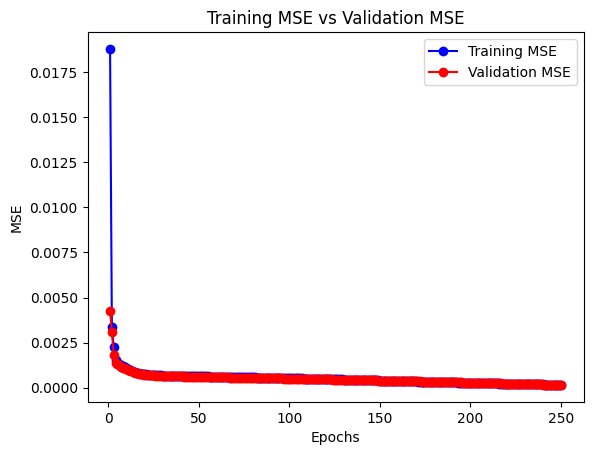

In [6]:
import matplotlib.pyplot as plt

# selected settings for regression (best fit from options above)
activation, optimizer, n_hidden_layers, n_nodes_per_layer = "tanh", "Adam", 4, 20
loss, metrics = "mse", ["mae", "mse"]

# Create data objects for training using scalar normalization
n_inputs = len(input_labels)
n_outputs = len(output_labels)
x = input_data
y = output_data

input_scaler = None
output_scaler = None
input_scaler = OffsetScaler.create_normalizing_scaler(x)
output_scaler = OffsetScaler.create_normalizing_scaler(y)
x = input_scaler.scale(x)
y = output_scaler.scale(y)
x = x.to_numpy()
y = y.to_numpy()

# Create Keras Sequential object and build neural network
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=n_nodes_per_layer, input_dim=n_inputs, activation=activation
    )
)
for i in range(1, n_hidden_layers):
    model.add(tf.keras.layers.Dense(units=n_nodes_per_layer, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs, activation=keras.activations.linear))

# Train surrogate (calls optimizer on neural network and solves for weights)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    ".mdl_co2.keras", save_best_only=True, monitor="val_loss", mode="min"
)
history = model.fit(
    x=x, y=y, validation_split=0.2, verbose=2, epochs=250, callbacks=[mcp_save]
)

# Get the training and validation MSE from the history
train_mse = history.history["mse"]
val_mse = history.history["val_mse"]

# Generate a plot of training MSE vs validation MSE
epochs = range(1, len(train_mse) + 1)
plt.plot(epochs, train_mse, "bo-", label="Training MSE")
plt.plot(epochs, val_mse, "ro-", label="Validation MSE")
plt.title("Training MSE vs Validation MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [7]:
# Adding input bounds and variables along with scalers and output variable to kerasSurrogate
xmin, xmax = [7, 306], [40, 1000]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

keras_surrogate = KerasSurrogate(
    model,
    input_labels=list(input_labels),
    output_labels=list(output_labels),
    input_bounds=input_bounds,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
)
keras_surrogate.save_to_folder(
    keras_folder_name="sco2_keras_surr", keras_model_name="sco2_keras_model"
)

### 2.3 Visualizing Surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


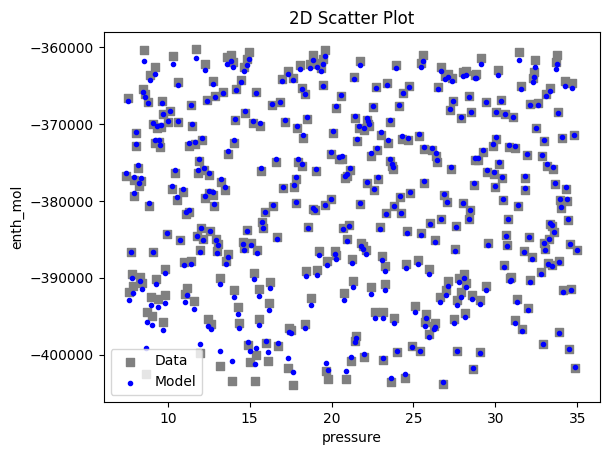

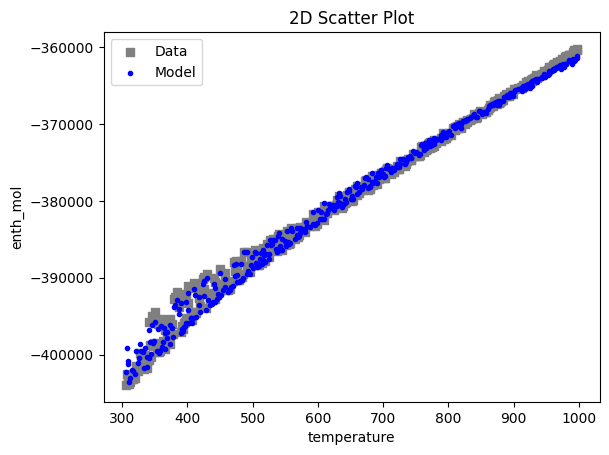

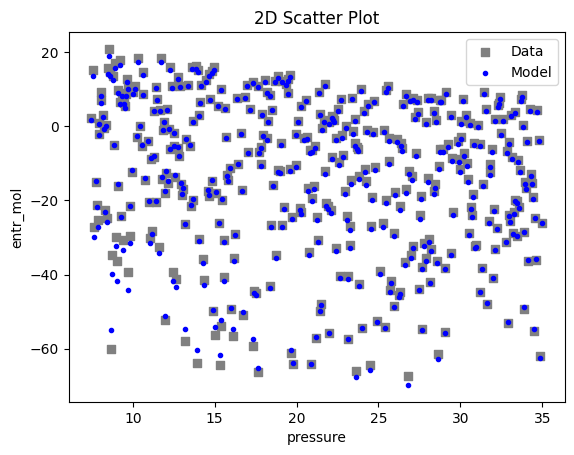

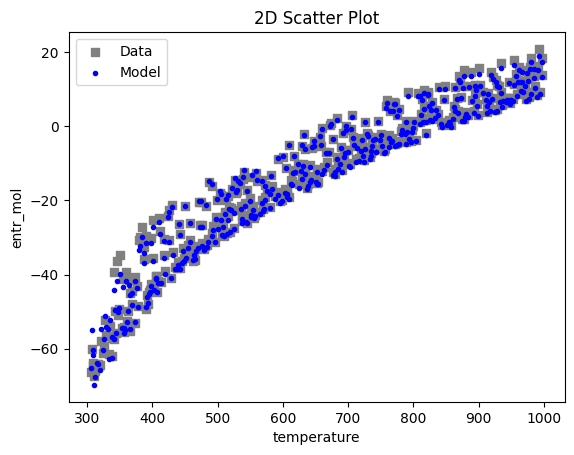

 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


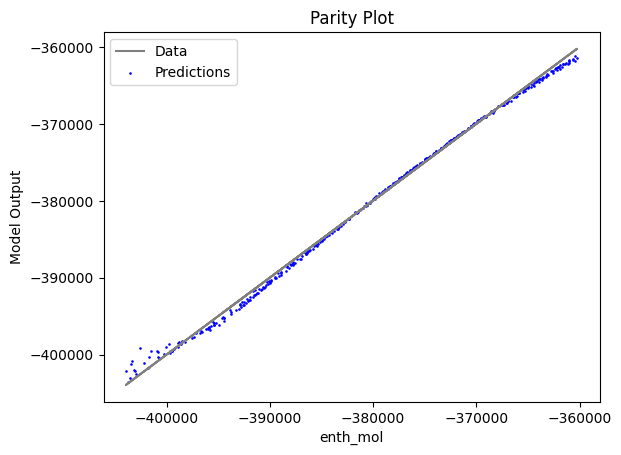

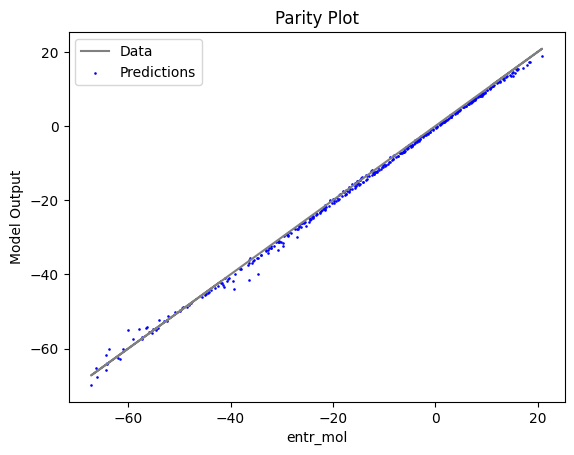

 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


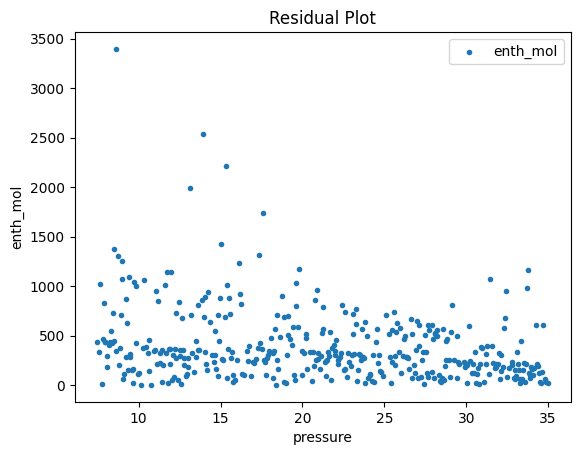

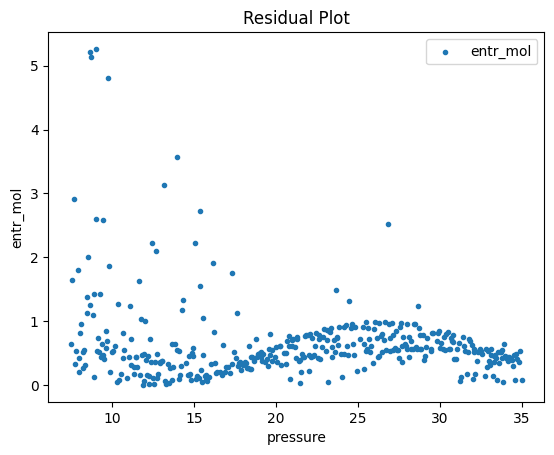

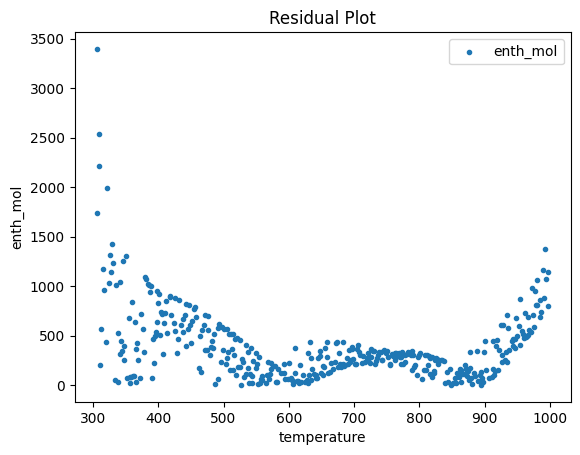

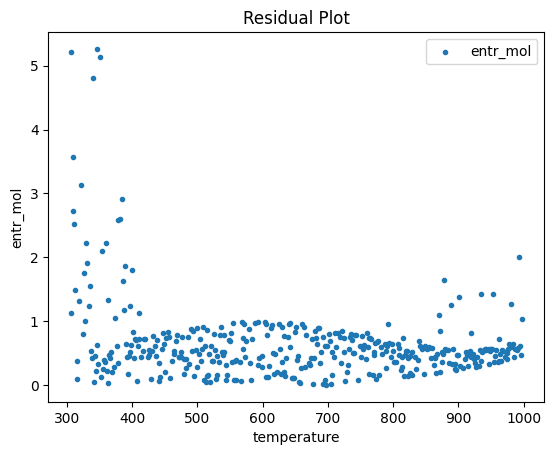

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [8]:
surrogate_scatter2D(keras_surrogate, data_training)
surrogate_parity(keras_surrogate, data_training)
surrogate_residual(keras_surrogate, data_training)

### 2.4 Model Validation

We check the fit on the validation set to see if the surrogate is fitting well. This step can be used to check for overfitting on the training set.

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


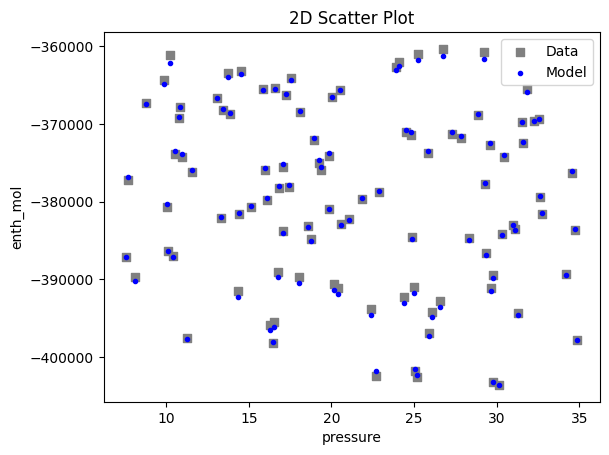

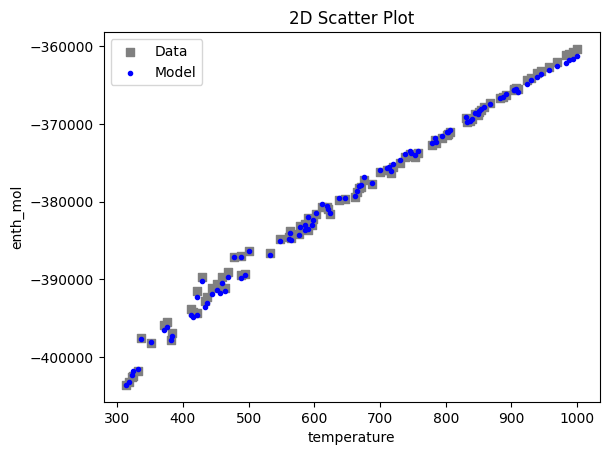

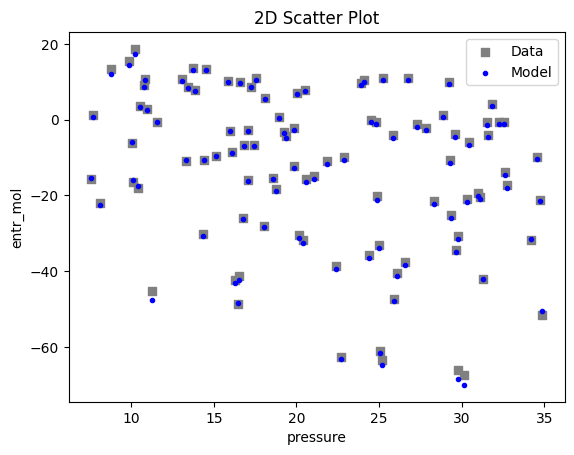

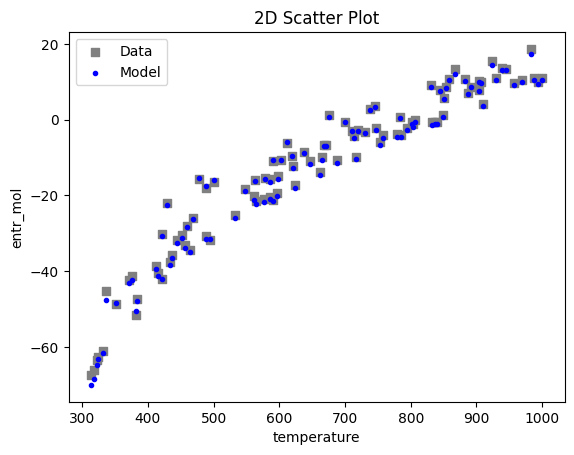

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


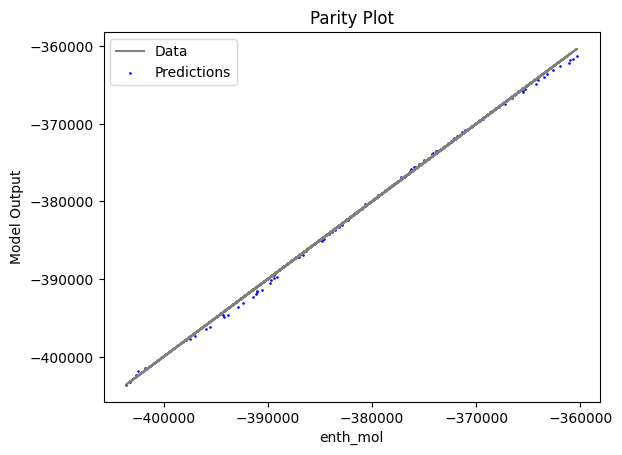

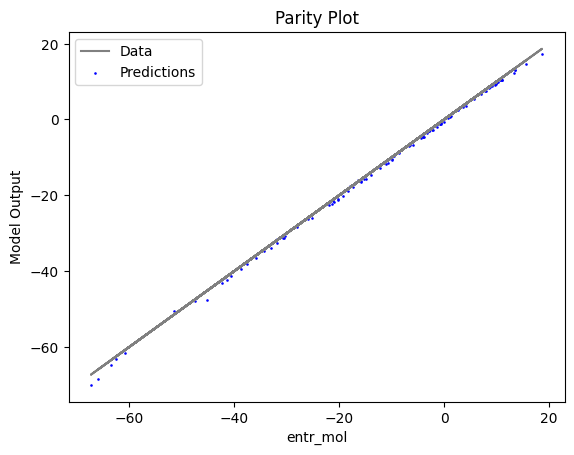

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


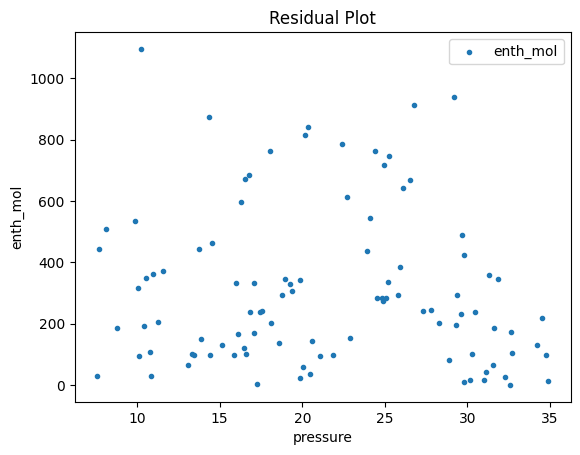

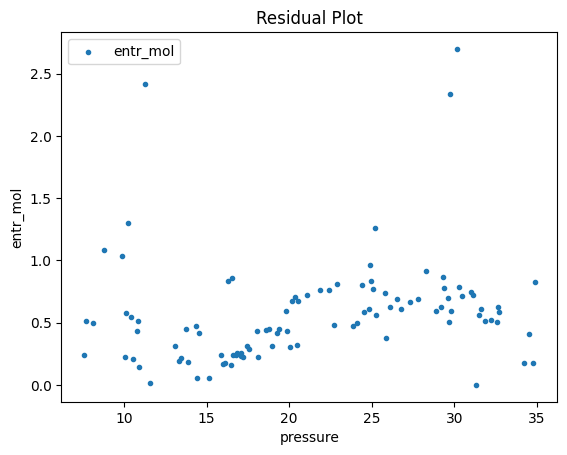

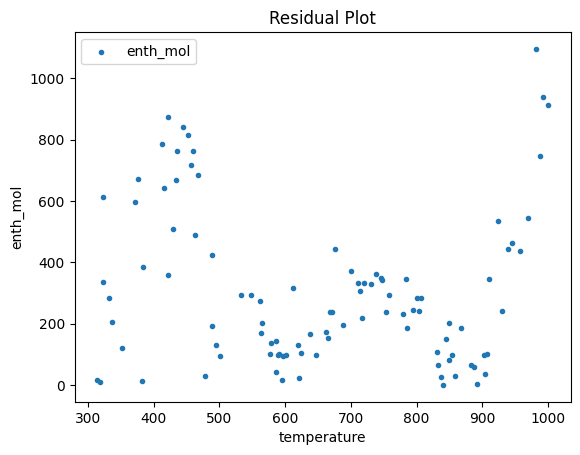

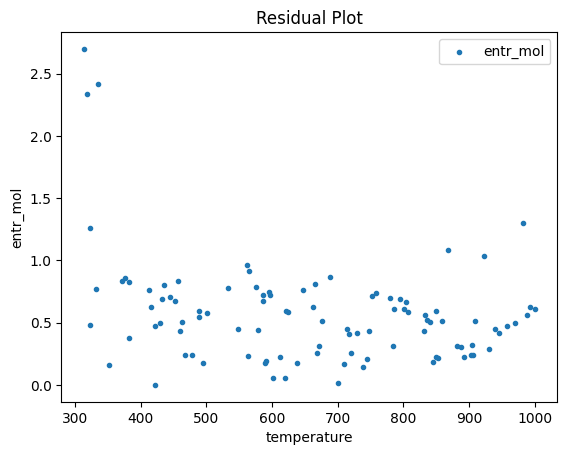

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [9]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(keras_surrogate, data_validation)
surrogate_parity(keras_surrogate, data_validation)
surrogate_residual(keras_surrogate, data_validation)

Now, the surrogate is trained and validated, we shall embed it in the property package, which is demonstrated in the [surrogate_embedding_doc.md](./surrogate_embedding_doc.md) file.